# Modelling Lottery Number Popularity


I want to reproduce the analysis of how to optimize playing the popular german 'Lotto 6 aus 49' Lottery with Machine learning. In this lottery six numbers out of 49 are drawn without replacement; on top a super number (Superzahl) from zero to nine is drawn as well slimming the odds of winning tier #1 to 1:139,838,160.

Contrary to some common belief which is also suggested by the lotteries themselves, you cannot pick certain numbers to increase your chances of winning at all. Because as we can assume (and gonna prove as well just to make sure) that the drawn number frequencies are uniformly distributed and have equal probability to be drawn, even if official number frequency statistics fed by the lottery itself are in place to make people believe one thing or another.

The focus of interest however in this analysis are going to be two questions I am interested in answering:

1. <strong>Which numbers are how popular among the mean lottery participant to be picked on their tickets?</strong> This is of interest because number popularity is inverse with profit share quota in all but the lowest winning tier.
  
2. <strong>Follow up question: In case that someone has a winning game, one really might want to be able to predict the profit share quota, being directly dependant on the popularities of the numbers being drawn.</strong> The prediction error needs to be low in order to have any use.

## Question 1: Number Popularities

### Data wrangling

the relevant data of the years 2017, 2018 and 2019 was downloaded from [westlotto.com](https://ergebnisse.westlotto.com/infoservice/sachsen/downloads/start.html) and processed solely as follows.

In [45]:
import pandas as pd

def pre19import(yearstring):
    df = pd.read_excel('LOTTO6aus49.xls', sheet_name=yearstring, skiprows=6, parse_dates=[0])
    df = df.drop(range(52,60),axis=0).copy()
    df.rename(columns = {'Unnamed: 1':'Date'}, inplace = True) 
    pd.to_datetime(df['Date']).apply(lambda x: x.date())
    df.set_index(["Date"], inplace = True)
    df.drop(df.columns[[0,1]], axis=1,inplace=True)
    df['Quote Kl. 9'] = 5
    df.columns = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S', 'Spieleinsatz', 'Anz. Kl. 1',
           'Quote Kl. 1', 'Anz. Kl. 2', 'Quote Kl. 2', 'Anz. Kl. 3', 'Quote Kl. 3',
           'Anz. Kl. 4', 'Quote Kl. 4', 'Anz. Kl. 5', 'Quote Kl. 5', 'Anz. Kl. 6',
           'Quote Kl. 6', 'Anz. Kl. 7', 'Quote Kl. 7', 'Anz. Kl. 8', 'Quote Kl. 8',
           'Anz. Kl. 9', 'Quote Kl. 9']
    df = df.replace({'Jackpot': 0, 'JP': 0, 'unbesetzt': 0}, regex=False)
    for c in df.columns:
        df[c] =  df[c].astype(float)
    for c in ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S']:
        df[c] =  df[c].astype(int)
    return df

df2017 = pre19import('2017')
df2018 = pre19import('2018')

df2017.head(5)

,G1,G2,G3,G4,G5,G6,S,Spieleinsatz,Anz. Kl. 1,Quote Kl. 1,...,Anz. Kl. 5,Quote Kl. 5,Anz. Kl. 6,Quote Kl. 6,Anz. Kl. 7,Quote Kl. 7,Anz. Kl. 8,Quote Kl. 8,Anz. Kl. 9,Quote Kl. 9
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-04,48,5,39,37,21,13,2,25783219.0,0.0,15050011.5,...,2095.0,232.4,20070.0,48.5,38274.0,25.4,384520.0,11.3,300502.0,5.0
2017-01-07,22,12,14,45,17,46,7,51173316.0,0.0,18325103.7,...,3920.0,238.5,29806.0,62.7,83095.0,22.5,649804.0,12.9,721377.0,5.0
2017-01-11,29,32,27,38,34,20,1,27596782.0,0.0,20091297.7,...,1957.0,269.0,19792.0,53.1,37841.0,27.8,402259.0,11.7,300590.0,5.0
2017-01-14,23,37,27,4,3,28,3,54716507.0,0.0,23593154.1,...,5342.0,185.2,44154.0,44.8,109456.0,18.0,902208.0,9.8,813548.0,5.0
2017-01-18,39,40,10,28,11,13,1,29278479.0,0.0,25466976.7,...,2685.0,204.6,26879.0,40.8,47706.0,23.0,496024.0,9.9,355380.0,5.0


In [46]:
df19 = pd.read_excel('LOTTO_ab_2019.xls',  index_col=0, parse_dates=[0], decimal=",", thousands='.')
df19.drop(df19.columns[[0,7,8,10,11]], axis=1,inplace=True)
df19 = df19.iloc[0:-4,:].copy()
df19.columns = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S', 'Spieleinsatz', 'Anz. Kl. 1',
           'Quote Kl. 1', 'Anz. Kl. 2', 'Quote Kl. 2', 'Anz. Kl. 3', 'Quote Kl. 3',
           'Anz. Kl. 4', 'Quote Kl. 4', 'Anz. Kl. 5', 'Quote Kl. 5', 'Anz. Kl. 6',
           'Quote Kl. 6', 'Anz. Kl. 7', 'Quote Kl. 7', 'Anz. Kl. 8', 'Quote Kl. 8',
           'Anz. Kl. 9', 'Quote Kl. 9']
df19 = df19.replace({'Jackpot': 0, 'JP': 0, 'unbesetzt': 0}, regex=False)
for c in ['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'S']:
    df19[c] =  df19[c].astype(int)


In [47]:
df19.shape

(104, 26)

In [48]:
df = pd.concat([df2017, df2018, df19])
print(df.shape)

(312, 26)


In [49]:
df.describe()

,G1,G2,G3,G4,G5,G6,S,Spieleinsatz,Anz. Kl. 3,Quote Kl. 3,...,Anz. Kl. 5,Quote Kl. 5,Anz. Kl. 6,Quote Kl. 6,Anz. Kl. 7,Quote Kl. 7,Anz. Kl. 8,Quote Kl. 8,Anz. Kl. 9,Quote Kl. 9
count,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,3.120000e+02,312.000000,312.000000,...,312.000000,312.000000,312.000000,312.000000,312.000000,312.000000,3.120000e+02,312.000000,312.000000,312.0
mean,25.657051,24.881410,25.185897,24.778846,24.326923,25.349359,4.692308,3.438957e+07,64.368590,11899.456090,...,3396.801282,201.160577,30022.865385,44.489103,61674.205128,21.348397,5.467567e+05,10.595513,461666.301282,5.0
std,14.224238,14.183072,14.542013,14.244956,13.838835,13.911632,2.787467,1.199418e+07,41.751701,4955.349056,...,1605.650050,54.818954,13052.189116,10.122555,25253.834506,4.497988,2.077233e+05,1.580421,176109.509368,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.919371e+07,14.000000,2452.500000,...,1296.000000,60.700000,12372.000000,19.100000,25526.000000,9.700000,2.587140e+05,6.400000,206333.000000,5.0
25%,13.750000,13.000000,12.000000,13.000000,13.000000,13.000000,2.000000,2.204758e+07,36.000000,8292.525000,...,2148.000000,159.050000,19090.750000,36.775000,39751.000000,18.200000,3.572440e+05,9.500000,299849.000000,5.0
50%,26.000000,25.000000,26.000000,25.000000,24.000000,26.000000,5.000000,3.926879e+07,53.000000,11223.100000,...,3036.000000,200.050000,27313.500000,44.000000,57392.000000,21.050000,5.480480e+05,10.600000,434740.000000,5.0
75%,38.000000,37.000000,37.250000,37.000000,35.000000,36.250000,7.000000,4.513643e+07,79.250000,14531.050000,...,4198.250000,236.075000,38337.500000,51.900000,80466.750000,24.225000,7.141132e+05,11.700000,616137.750000,5.0
max,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,9.000000,6.136400e+07,316.000000,32911.200000,...,12199.000000,351.500000,77355.000000,73.100000,151438.000000,34.800000,1.104307e+06,15.000000,919597.000000,5.0


In [50]:
import numpy as np
#dfclass8 = df.iloc[:,np.r_[0:6,7,23:25]]
dfclass8 = pd.DataFrame()
dfclass8 = df.iloc[:,np.r_[0:6,23:24]].copy()
dfclass8.rename(columns = {'Quote Kl. 8':'quota_EUR_8'}, inplace=True)

# Winning class 6 + 8
dfclass6_8 = df.iloc[:,np.r_[0:6,19:20,23:24]].copy()
dfclass6_8.rename(columns = {'Quote Kl. 6':'quota_EUR_6'}, inplace=True)
dfclass6_8.rename(columns = {'Quote Kl. 8':'quota_EUR_8'}, inplace=True)

# Winning class 7 for 'Superzahl' analysis
dfclass7 = df.iloc[:,np.r_[6,21:22]].copy()
dfclass7.rename(columns = {'Quote Kl. 7':'quota_EUR_7'}, inplace=True)
dfclass7.rename(columns = {'S':'Superzahl'}, inplace=True)

# Winning class 5 for 'Superzahl' analysis
dfclass5 = df.iloc[:,np.r_[6,17:18]].copy()
dfclass5.rename(columns = {'Quote Kl. 5':'quota_EUR_5'}, inplace=True)
dfclass5.rename(columns = {'S':'Superzahl'}, inplace=True)

In [51]:
def sparsedf(df, numbers=6, pop=49): # custom hot encoding
    for i in range(1,pop+1):
        df.loc[:,'N' + str(i)] = pd.Series(np.zeros((len(df)))) #sparse cols
    df = df.fillna(0) # zero prefilled
    num = range(1,numbers+1)
 
    for index, row in df.iterrows(): # each drawing
        for h in num: # each drawn number
            dn = df.iloc[index,h].copy()
            df.loc[index,'N' + str(dn)] = 1 # sparsing
    return df

In [52]:
dfclass8.reset_index(inplace=True)
dfclass8 = sparsedf(dfclass8)

dfclass8

,index,G1,G2,G3,G4,G5,G6,quota_EUR_8,N1,N2,...,N40,N41,N42,N43,N44,N45,N46,N47,N48,N49
0,2017-01-04 00:00:00,48,5,39,37,21,13,11.3,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2017-01-07 00:00:00,22,12,14,45,17,46,12.9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,2017-01-11 00:00:00,29,32,27,38,34,20,11.7,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-01-14 00:00:00,23,37,27,4,3,28,9.8,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-01-18 00:00:00,39,40,10,28,11,13,9.9,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,14.12.2019,4,20,31,16,38,34,9.9,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308,18.12.2019,25,42,6,48,20,19,10.9,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
309,21.12.2019,27,4,13,14,35,20,12.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
310,25.12.2019,47,41,33,36,22,17,10.5,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [53]:
# expecting a uniform distribution of drawn numbers across population 1 -49
dfclass8.sum()[7:58]

N1     39.0
N2     33.0
N3     49.0
N4     40.0
N5     41.0
N6     42.0
N7     36.0
N8     29.0
N9     39.0
N10    28.0
N11    38.0
N12    37.0
N13    42.0
N14    30.0
N15    38.0
N16    38.0
N17    38.0
N18    45.0
N19    44.0
N20    35.0
N21    32.0
N22    40.0
N23    38.0
N24    35.0
N25    44.0
N26    31.0
N27    47.0
N28    32.0
N29    51.0
N30    35.0
N31    48.0
N32    33.0
N33    38.0
N34    33.0
N35    35.0
N36    46.0
N37    43.0
N38    40.0
N39    32.0
N40    38.0
N41    36.0
N42    46.0
N43    23.0
N44    35.0
N45    40.0
N46    40.0
N47    46.0
N48    37.0
N49    37.0
dtype: float64

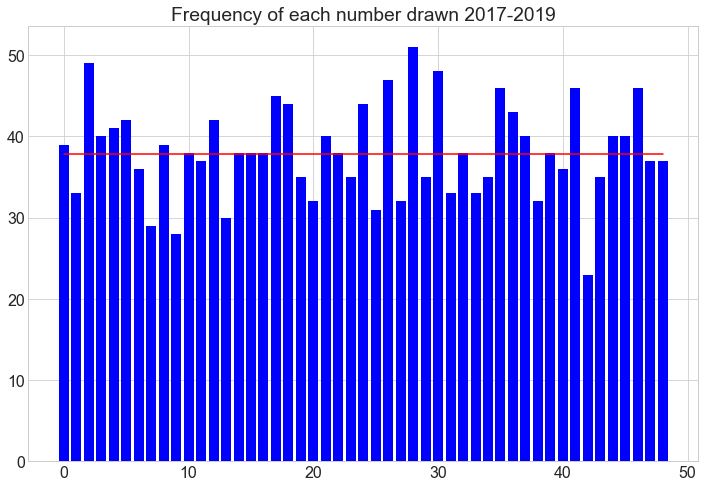

<Figure size 960x480 with 0 Axes>

38.204081632653065


In [54]:
# plotting
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = [12, 8] # for square canvas
plt.rcParams.update({'font.size': 16})

data = [23, 45, 56, 78, 213]
plt.bar(range(len(dfclass8.sum()[7:58])), dfclass8.sum()[7:58], color='blue')
nn = np.linspace(1,50)
plt.plot(range(len(dfclass8.sum()[7:58])),[37.8367 for w in dfclass8.sum()[7:58]],'r')
plt.title('Frequency of each number drawn 2017-2019')
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.show()
print(dfclass8.sum()[7:58].mean())

### Assumption: frequency distribution of drawn lotto numbers is uniform

This lotto game business is a multi-million EUR business and is certainly scrutizined all over sufficiently;
nevertheless I will run a quick test to verify uniformity and reject any bias in each numbers defacto probability to be drawn.

In [55]:
# goodness of fit - test

# frequency of numbers drawn
number_draws_observed = dfclass8.sum()[7:58].to_numpy()

# 1854 numbers drawn in 309 drawing sessions across the 49 number population, 
# with an expected mean of each number to show up of 37.83673469387755 times (see also appendix)
# create a strictly uniform expected dist.
number_draws_expected = [38.44897959183673 for w in dfclass8.sum()[7:58]]
#print('number_draws_expected' ,number_draws_expected)
#print('   ')

# compare both distributions and compare
from scipy.stats import chisquare, chi2_contingency
test = chisquare(f_obs=number_draws_observed, f_exp=number_draws_expected)
print(test)
print(round(test[1],3))

Power_divergenceResult(statistic=42.417197452229296, pvalue=0.7001128685392815)
0.7


Conclusion:
The p-value shows the confidence that the drawn frequency set originates more likely than not from a uniform distribution. That means that the number balls used in the drawings are indeed fair. Nothing else did we expect from the professional organizers of the national lottery in Germany.

Our Null Hypothesis states that the number draw frequency distribution is uniform. This Null Hypothesis is not rejected due to the high p-value and quite comfortably confirmed.

### Modeling number popularity

The problem is of linear nature with many linear equations that need to be solved. We want to find the best coefficients with a low error margin for all numbers involved given this dataset. This will allow us on the one hand to see the relative number pick frequencies and therefore popularities. One the other hand it will allow us to estimate and predict possible quotas for a winning tier. We are curious to which degree (margin of error) this will be possible, especially in the knowledge that there are overlaying complex factors (features) involved having potential large bias that we have to disregard at this point.

As discussed by [Werner Brefeld](http://brefeld.homepage.t-online.de/lottoquoten.html), the problem of popular symmetric and or pattern picks is latent which assumes interdependant relations of picked numbers on one ticket which cannot be taken into account just now. Background: a few number drawings are on record where numbers being drawn constituted (symmetric) patterns on the ticket which warranted surprisingly many winners and thus low quotas and sub average profit shares.

#### Splitting data

In [56]:
dfclass8_X = pd.DataFrame(dfclass8.iloc[:,8:58])
dfclass8_y = dfclass8.iloc[:,7].to_numpy()

dfclass7_X = pd.DataFrame(dfclass7.iloc[:,2:12])
dfclass7_y = dfclass7.iloc[:,0].to_numpy()

from sklearn.model_selection import train_test_split
SEED = 1
# As usually we split the data into a training and test data set (X_train, y_train, and X_test, y_test)
# winning tier 8 ( three correct numbers )
X_train, X_test, y_train, y_test = train_test_split(dfclass8_X, dfclass8_y, test_size=0.11, random_state=SEED)
# winning tier 7 ( three correct numbers and correct Superzahl )
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(dfclass7_X, dfclass7_y, test_size=0.15, random_state=SEED)

print('Train data shape 8 / 7:', X_train.shape, X_train_7.shape)
print('Test data shape 8 / 7: ', X_test.shape, X_test_7.shape)

Train data shape 8 / 7: (277, 49) (265, 0)
Test data shape 8 / 7:  (35, 49) (47, 0)


In [57]:
#imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.kernel_ridge import KernelRidge

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [58]:
#model definitions
all_param = pd.Series()

In [59]:
queue = [
       
         ( 
            'linreg',
            LinearRegression(copy_X=True),
            {},
            'coef_'
         ),
        (
            'ridge',
            Ridge(random_state=SEED,
             copy_X=True
            ),
            {
                'alpha': [1, 1.25, 1.5, 1.75,],
                'max_iter': [ 200,300, 400, 500,600, 1000, 2000],
                'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
             },
            'coef_'
        ),
    (
            'lasso',
            Lasso(random_state=SEED,
             #copy_X=True
            ),
                {
                'alpha': [0.001, 0.0015,0.002, 0.0025, 0.003, 0.004, 0.005, 0.0075,  ],
                'max_iter': [  300, 400,500,700,900],
             },
            'coef_'
    ),
    (
            'bayesridge',
            BayesianRidge(
                copy_X=True,
                lambda_1=0.2,
            ),

                {
                'alpha_1': [
                                    0.001, 0.0015,0.002, 0.0025, 0.003, 0.0004, 0.0005, 0.000001, 0.0000001,
                                    #0.25, 0.5, 0.75, 1, 1.5, 2, 3, 5,
                                    #0.6
                                ],
                'lambda_1': [
                                    0.001, 0.0015,0.002, 0.0025, 0.003, 0.0004, 0.0005, 0.000001,
                                ],
                'n_iter': [100,200,300,400,500,1000],
             },
            'coef_'
    ),
    (
            'sgd',
            SGDRegressor(
                random_state=SEED
            ),

                {
                'alpha': [
                                    0.001, 0.0015,0.002, 0.0025, 0.003, 0.001, 0.0004, 0.0005, 0.000001,
                                    #0.25, 0.5, 0.75, 1, 1.5, 2, 3, 5,
                                    #0.6
                                ],
                'l1_ratio': [
                                    0.005,0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 1,
                                ],
                'max_iter': [300,400,500,1000, 2000],
             },
            'coef_'
    ),
    (
            'linsvr',
            LinearSVR(
               
            ),

                {
                 
                'epsilon': [
                                    0.1, 0.125, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6,0.075,  0.05
                                    #0.25, 0.5, 0.75, 1, 1.5, 2, 3, 5,
                                    #0.6
                                ],
                'tol': [
                                    0.025,0.04,0.05, 0.06,0.07,0.875, 0.1,0.15
                                ],
               
                'C': [ 0.5, 0.7 , 0.9, 1,1.1,1.2,1.5, 2],
                 'max_iter': [ 400,700,1000,1200,1500,2000,3000],    
             },
            'coef_'
    )
]



#### Training the models with the designated Training Data

In [60]:
%%time
#gs
from loky import get_reusable_executor
get_reusable_executor(max_workers=4, timeout=500)
                           
for name, model, param, attribute in queue[0:6]:
    
    gs = GridSearchCV(model,param,cv=10,n_jobs=-1,scoring='neg_mean_squared_error' )
    gs.fit(X_train, y_train)
    all_param[name] = gs.best_params_
    print(gs.best_score_, name, gs.best_params_)

print(' ')
print(all_param)

-0.5137008463541667 linreg {}
-0.499170913350898 ridge {'alpha': 1, 'max_iter': 200, 'solver': 'lsqr'}
-0.5045677907193077 lasso {'alpha': 0.001, 'max_iter': 300}
-0.499807108597921 bayesridge {'alpha_1': 1e-07, 'lambda_1': 0.003, 'n_iter': 100}
-0.5658040444210715 sgd {'alpha': 1e-06, 'l1_ratio': 0.005, 'max_iter': 300}
-0.46751104893377554 linsvr {'C': 2, 'epsilon': 0.4, 'max_iter': 1000, 'tol': 0.07}
 
linreg                                                       {}
ridge           {'alpha': 1, 'max_iter': 200, 'solver': 'lsqr'}
lasso                         {'alpha': 0.001, 'max_iter': 300}
bayesridge    {'alpha_1': 1e-07, 'lambda_1': 0.003, 'n_iter'...
sgd           {'alpha': 1e-06, 'l1_ratio': 0.005, 'max_iter'...
linsvr        {'C': 2, 'epsilon': 0.4, 'max_iter': 1000, 'to...
dtype: object
Wall time: 44.4 s


In [61]:
print(len(queue))

6


#### Model performances with the designated Test Data

In [62]:
from sklearn import metrics

model_weights = pd.DataFrame({'number': range(1,50)})

for name, model, param, attribute in queue[0:6]:
    
    regr = model
    regr.set_params(**all_param[name]) # fit best scoring grid searched model
       
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    print(name, ' --------------')

    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    
    model_weights[name] = getattr(regr,attribute)

model_weights =  model_weights.iloc[:,1:5]

linreg  --------------
Mean Squared Error: 0.3932198137555803
Root Mean Squared Error: 0.6270724150810497
ridge  --------------
Mean Squared Error: 0.4175507363196435
Root Mean Squared Error: 0.6461816589161623
lasso  --------------
Mean Squared Error: 0.40068699983278666
Root Mean Squared Error: 0.6329984200871174
bayesridge  --------------
Mean Squared Error: 0.4190189105968596
Root Mean Squared Error: 0.6473167003846414
sgd  --------------
Mean Squared Error: 0.6016390734541474
Root Mean Squared Error: 0.7756539650218693
linsvr  --------------
Mean Squared Error: 0.44471191050978526
Root Mean Squared Error: 0.6668672360446157


The linsvr model is not robust enough for the test data to confirm the cross validated performance. This model is certainly overfitted. We have to keep this is in mind when looking at the coefficents right next.

### Modeled Feature Coefficents/Importances (= number popularity)

#### The Regular Six Numbers (One to 49)

which features (=numbers) do correlate with a higher profit share (=less winners) and which do less?

In [63]:
# normalization
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

weights = model_weights.iloc[:,:].copy()
scaler = StandardScaler()

for n in weights.columns:
    np_array = np.array(weights[n].values)
    arr = scaler.fit_transform(np_array.reshape(-1, 1))
    weights[n] = arr

Having a peak into the data...
  number    linreg     ridge     lasso  bayesridge
1      1  0.425204  0.438354  0.435677    0.437859
2      2 -0.143301 -0.073384 -0.055878   -0.074180
3      3 -1.461983 -1.486128 -1.474541   -1.488115
4      4 -0.563024 -0.616321 -0.591879   -0.615952
5      5 -1.170683 -1.207236 -1.190398   -1.208406
6      6 -1.134662 -1.119764 -1.121690   -1.121097
7      7 -2.112710 -2.116024 -2.137002   -2.116752


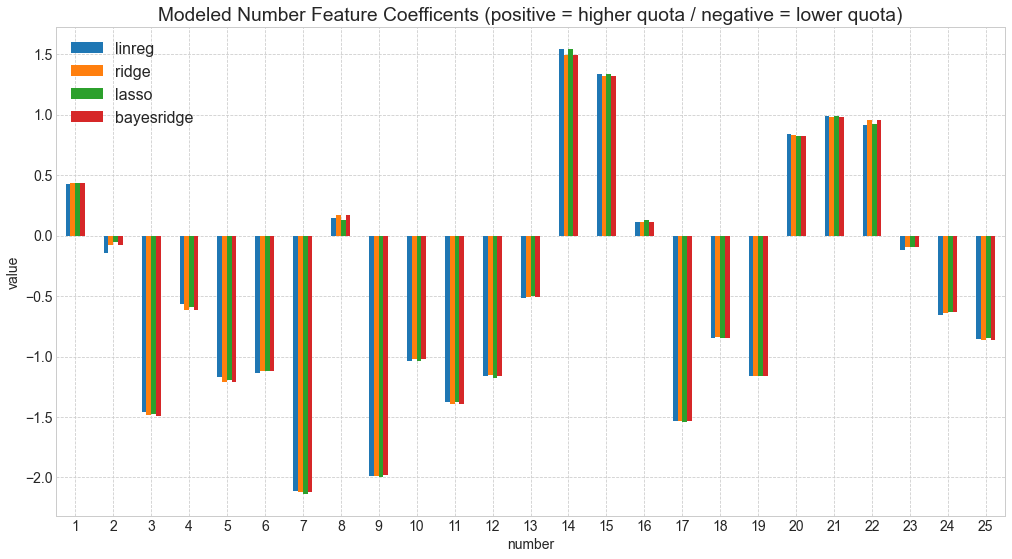

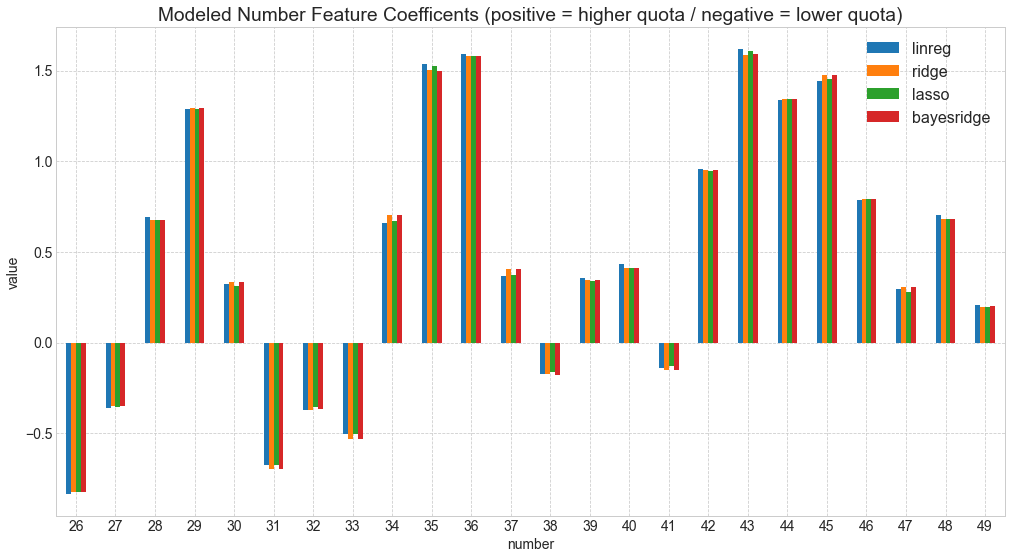

In [64]:
# plotting popularity

import pandas as pd

model_weights = pd.DataFrame({'number': range(1,50)})
model_weights['number'] = model_weights['number'].astype(str) #convert
#model_weights.reindex([model_weights['number'])

model_weights = pd.concat([model_weights, weights], axis=1)
model_weights.set_index('number')
model_weights.index += 1 
print('Having a peak into the data...')
print(model_weights.head(7))

#prepare two df for df.plot   
dfplot_mw1 = model_weights[0:25][['linreg','ridge','lasso', 'bayesridge']].copy()
dfplot_mw2 = model_weights[25:50][['linreg','ridge','lasso', 'bayesridge']].copy()

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

a = dfplot_mw1.plot(kind='bar', 
                    title ="Modeled Number Feature Coefficents (positive = higher quota / negative = lower quota)", figsize=(17, 9), legend=True, fontsize=14)
plt.xticks(rotation=0)

b = dfplot_mw2.plot(kind='bar', 
                    title ="Modeled Number Feature Coefficents (positive = higher quota / negative = lower quota)", figsize=(17, 9), legend=True, fontsize=14)
ax = [a,b]

for axis in ax: 
    axis.set_xlabel("number", fontsize=14)
    axis.set_ylabel("value", fontsize=14)
    
    major_ticks = np.arange(0, 24, 10)
    minor_ticks = np.arange(0, 24, 5)

    axis.grid(which='major', color='#CCCCCC', linestyle='--')
    axis.grid(which='minor', color='#CCCCCC', linestyle=':')

    axis.grid(True)


plt.xticks(rotation=0)
plt.show()

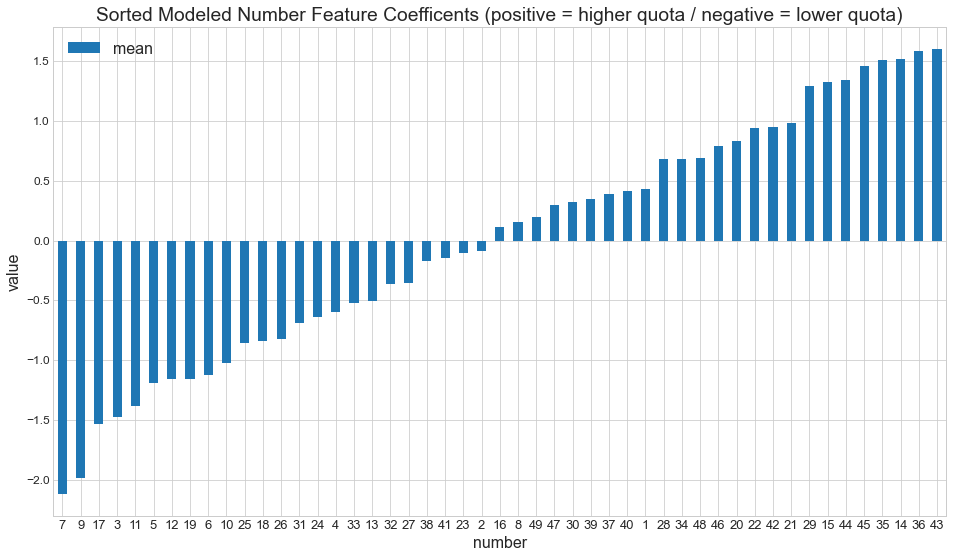

number    1225.000000
mean         0.006656
dtype: float64

In [65]:
mean_weights = pd.DataFrame({'number': range(1,50)})
mean_weights.index += 1 
mean_weights['mean'] = model_weights.mean(axis=1)
sorted_mean_weights = mean_weights.sort_values('mean')

axx = sorted_mean_weights[0:50][['mean']].plot(kind='bar', title ="Sorted Modeled Number Feature Coefficents (positive = higher quota / negative = lower quota)", figsize=(16, 9), legend=True, fontsize=12)
plt.xticks(rotation=0, fontsize=13)
plt.xlabel("number", fontsize=16)
plt.ylabel("value", fontsize=16)
plt.show()

mean_weights.sum()

In [66]:
mean_weights.drop(mean_weights.columns[[0]], axis=1,inplace=True)

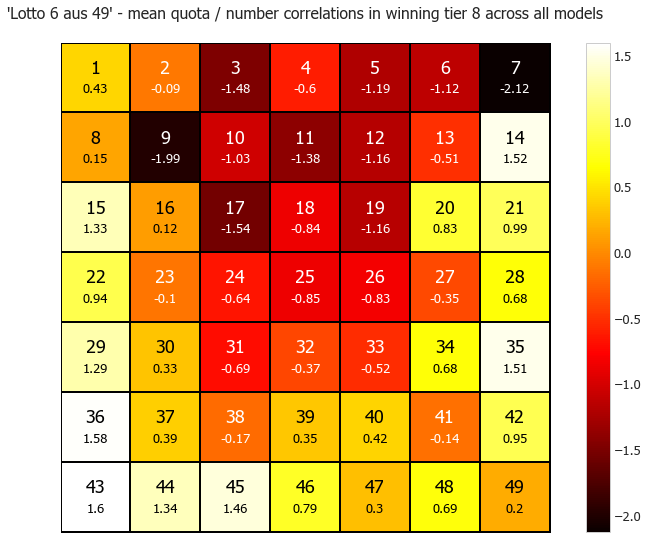

In [67]:
size = 7
data = mean_weights.to_numpy().reshape((size, size))
values = mean_weights.to_numpy().reshape((size, size))
idx = mean_weights.index.to_numpy().reshape((size, size))

# plot based on https://stackoverflow.com/a/45989759 Ramon Martinez
font = {'family' : ['Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana'],
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

# Limits for the extent
x_start = 1
x_end = 8
y_start = 8
y_end = 1

extent = [x_start, x_end, y_start, y_end]

# The normal figure
fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111)

im = ax.imshow(data, extent=extent, origin='upper', interpolation='None', cmap='hot')

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_end, stop=y_start, num=size, endpoint=False)

for x_index, x in enumerate(x_positions):
    for y_index, y in enumerate(y_positions):
        label = np.round(values[y_index, x_index],2)
        label2 = idx[y_index, x_index]
        text_x = x + jump_x
        text_x2 = x + jump_x
        text_y = y - jump_y*1.35
        text_y2 = y - jump_y*0.75
        if label < 0:
            txtcol = 'white'
        else:
            txtcol = 'black'
        ax.text(text_x, text_y, label, color=txtcol, ha='center', va='center')
        ax.text(text_x2, text_y2, label2, color=txtcol, ha='center', va='center').set_fontsize(18)

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 8, 1));
ax.set_yticklabels(np.arange(1, 8, 1));

# Gridlines based on minor ticks
gridcol= 'black'
ax.grid(which='major', color=gridcol, linestyle='-', linewidth=2)
ax.spines['bottom'].set_color(gridcol)
ax.spines['top'].set_color(gridcol) 
ax.spines['right'].set_color(gridcol)
ax.spines['left'].set_color(gridcol)
ax.tick_params(axis='x', colors=gridcol)
ax.tick_params(axis='y', colors=gridcol)
ax.set_title('\'Lotto 6 aus 49\' - mean quota / number correlations in winning tier 8 across all models\n')

fig.colorbar(im)
plt.setp(ax.get_xticklabels(), visible=False)
plt.setp(ax.get_yticklabels(), visible=False)
#plt.tight_layout(pad=0)
plt.show()

The heatmap shows the higher quotas with less often played numbers with its positive coefficents towards colour white.
And quite the opposite with dark red towards black the extremly low expected quotas with the most popular numbers.

The recommendation could be summarized as such: <b>
1. Avoid the black holes at all cost, particularly 7, 9 and 17 and/or red in general.
2. Play preferably white and (light) yellowish backgrounded (black font) numbers only.
</b>

#### The Superzahl (zero to nine)

##### 1st Approach with Machine Learning

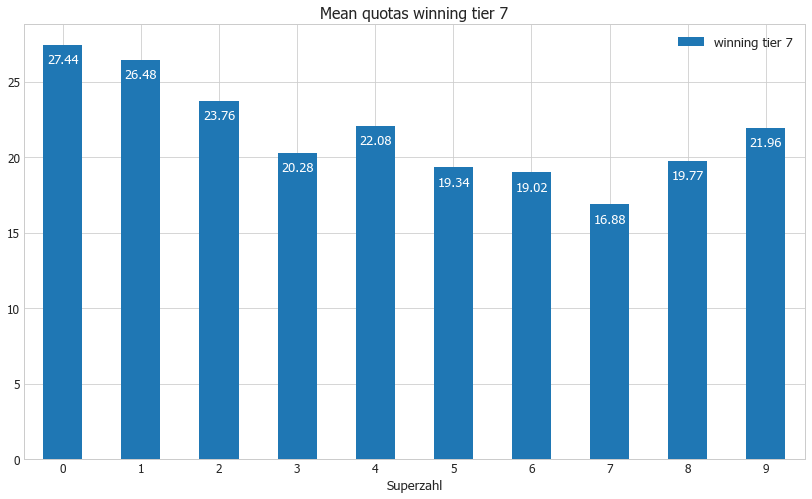

quota_EUR_7    21.699755
dtype: float64

In [68]:
dfcl7mean = dfclass7.groupby('Superzahl').mean()
dfcl5mean = dfclass5.groupby('Superzahl').mean()
import matplotlib.cm as cm

ax = dfcl7mean[0:10].plot(kind='bar', title ="Mean quotas winning tier 7", figsize=(14, 8), 
                             legend=True, fontsize=12)

for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2), (p.get_x()+p.get_width()/2., p.get_height()), 
                                 ha='center', va='center', color='w', xytext=(0, -15), textcoords='offset points')
ax.legend(["winning tier 7"]);  
plt.xticks(rotation=0)
plt.show()
dfcl7mean.mean()

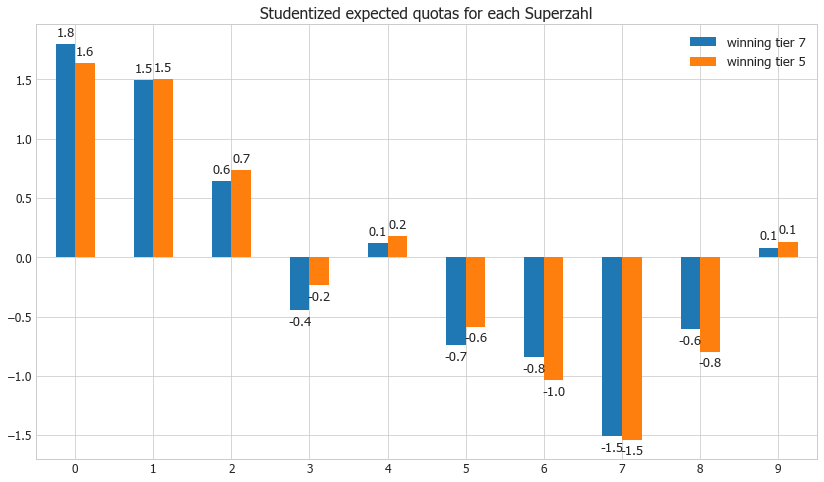

In [69]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn import preprocessing
from decimal import Decimal

dfcl7mean['quota_EUR_5'] = dfcl5mean['quota_EUR_5']
scaler = StandardScaler(with_std=True)
scaler.fit(dfcl7mean)
dfcl7mean_scaled = pd.DataFrame(scaler.transform(dfcl7mean), columns = dfcl7mean.columns)
ax = dfcl7mean_scaled[0:10].plot(kind='bar', title ="Studentized expected quotas for each Superzahl", figsize=(14, 8), legend=True, fontsize=12)

# from https://stackoverflow.com/a/48372659 thank you 'justfortherec'
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
ax.legend(["winning tier 7", "winning tier 5"]);
plt.xticks(rotation=0)
plt.show()


##### 2nd Approach with Comparing adjacent winning tiers with and without Superzahl

This approach is certainly preferred as the influence of the Superzahl and its popularity can be fully isolated due to the structuring of the winning tiers.

In [70]:
%%time
dfsuperzahl = pd.DataFrame(df[['S','Anz. Kl. 7', 'Anz. Kl. 8','Anz. Kl. 5', 'Anz. Kl. 6','Anz. Kl. 3', 'Anz. Kl. 4']])
#print(dfsuperzahl['Anz. Kl. 7'])

def threeright(row):
    return row['Anz. Kl. 7'] / row['Anz. Kl. 8'] * 10

def fourright(row):
    return row['Anz. Kl. 5'] / row['Anz. Kl. 6'] * 10

def fiveright(row):
    return row['Anz. Kl. 3'] / row['Anz. Kl. 4'] * 10

dfsuperzahl['quotient_threeright'] = df.apply(threeright, axis=1)
dfsuperzahl['quotient_fourright'] = df.apply(fourright, axis=1)
dfsuperzahl['quotient_fiveright'] = df.apply(fiveright, axis=1)
dfsuperzahl.drop(dfsuperzahl.columns[[1,2,3,4,5,6]], axis=1,inplace=True)
#print(dfsuperzahl)
dfsz = pd.DataFrame()
dfsz = dfsuperzahl.groupby('S').mean()
dfsz

Wall time: 21.5 ms


,quotient_threeright,quotient_fourright,quotient_fiveright
S,,,
0,0.845779,0.854405,0.875328
1,0.948027,0.951227,0.955890
2,1.004822,1.004100,0.961467
3,1.180298,1.178607,1.156610
4,1.064976,1.062544,1.042043
5,1.269253,1.276096,1.214365
6,1.205013,1.206128,1.172710
7,1.350242,1.354437,1.283479
8,1.171411,1.175044,1.252231


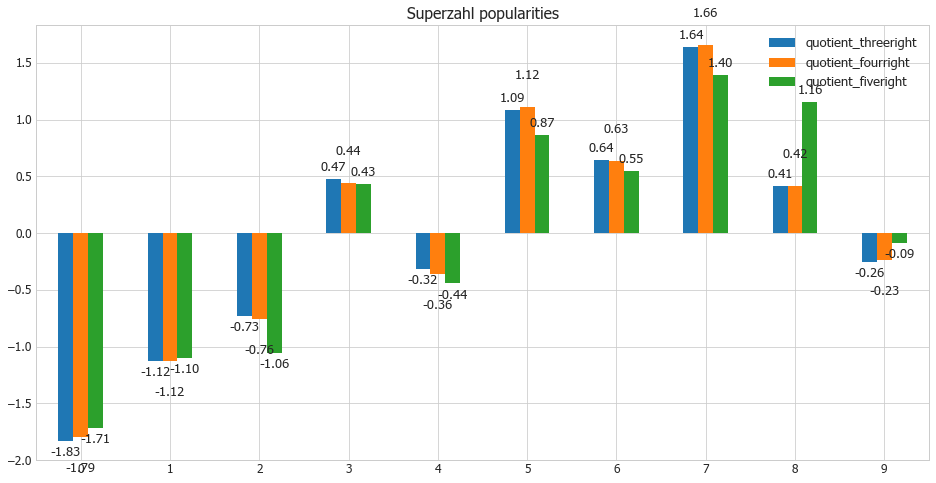

In [71]:
# standarize values with a mean of 0

from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
scaler = StandardScaler(with_std=True)
scaler.fit(dfsz)
dfsz_scaled = pd.DataFrame(scaler.transform(dfsz), columns = dfsz.columns)

ax = dfsz_scaled.plot(kind='bar', title ="Superzahl popularities", figsize=(16, 8), legend=True, fontsize=12)

# from https://stackoverflow.com/a/48372659 thank you 'justfortherec'
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        if (x_value % 1) == 0.0:
            space = spacing * 5
        else:
            space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.2f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.
add_value_labels(ax)
plt.xticks(rotation=0)
#plt.legend(loc=4)
plt.show()


Pretty clear preferences also with the super numbers (Superzahl). Very popular is again number 7 and also number 5.
Least played numbers are number 0 and number 1 for which one can expect on average a lot higher payout quotas in case that 
your ticket wins. And the best thing is again that you can determine this factor all by yourself on your ticket.

The problem with winning tiers three and four with five correct numbers on the ticket is that is has considerably less winners and lower numbers in total. All in all the green values hardly deviate that much, except for instance Superzahl 8.

Only minor differences can be seen when comparing both approaches number 1 and number 2.

## Question 2: Winning Tier Quota Prediction

In [72]:
# Split Data with numbers and superzahl combined into Train and Test Data
dfclass8sz = pd.DataFrame()
dfclass8sz = df.iloc[:,np.r_[0:7,23:24]].copy()
dfclass8sz.reset_index(inplace=True)
dfclass8sz.rename(columns = {'Quote Kl. 8':'quota_EUR_8'}, inplace=True)
dfclass8sz = sparsedf(dfclass8sz)
del dfclass8sz['index']
dfclass8sz['S'] = pd.Categorical(dfclass8sz.S)
dfclass8sz = pd.get_dummies(dfclass8sz, prefix_sep='')
dfclass8sz_X = pd.DataFrame(dfclass8sz.iloc[:,7:67]).copy()
dfclass8sz_y = dfclass8sz.iloc[:,6].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(dfclass8sz_X, dfclass8sz_y, test_size=0.15, random_state=SEED)

we could use plain vanilla linear regression as in Q1 however I want to see what is possible and we try to boost ourt predictions. In order to achieve better predictions and lower prediction errors we use <b>Stacking Generalization </b> to improve the model(s).

In [73]:
%%time
all_param_sz = pd.Series()

#gs
from loky import get_reusable_executor
get_reusable_executor(max_workers=4, timeout=500)
                           
for name, model, param, attribute in queue[0:6]:
    
    gs = GridSearchCV(model,param,cv=5,n_jobs=1,scoring='neg_mean_squared_error' )
    gs.fit(X_train, y_train)
    all_param_sz[name] = gs.best_params_
    print(gs.best_score_, name, gs.best_params_)

print(' ')
print(all_param_sz)


-0.6354882835532135 linreg {}
-0.4981811378793223 ridge {'alpha': 1.25, 'max_iter': 200, 'solver': 'saga'}
-0.49952464129780694 lasso {'alpha': 0.003, 'max_iter': 300}
-0.5012261021549107 bayesridge {'alpha_1': 1e-07, 'lambda_1': 1e-06, 'n_iter': 100}
-0.5877365551338707 sgd {'alpha': 1e-06, 'l1_ratio': 0.005, 'max_iter': 300}
-0.48804123430515334 linsvr {'C': 1.5, 'epsilon': 0.1, 'max_iter': 700, 'tol': 0.025}
 
linreg                                                       {}
ridge         {'alpha': 1.25, 'max_iter': 200, 'solver': 'sa...
lasso                         {'alpha': 0.003, 'max_iter': 300}
bayesridge    {'alpha_1': 1e-07, 'lambda_1': 1e-06, 'n_iter'...
sgd           {'alpha': 1e-06, 'l1_ratio': 0.005, 'max_iter'...
linsvr        {'C': 1.5, 'epsilon': 0.1, 'max_iter': 700, 't...
dtype: object
Wall time: 2min 8s


### Stacking Generalization with py package vecstack

[Vecstack](https://github.com/vecxoz/vecstack)

#### Set of 1st level models

In [74]:
# add non-linear high performing algos
svr_param = {'C': 0.075, 'coef0': 5, 'degree': 3, 'epsilon': 0.075, 'kernel': 'poly'}
kr_param = {'alpha': 0.6, 'coef0': 2, 'degree': 7, 'kernel': 'polynomial'}

models = [

    ('linreg', LinearRegression(**all_param_sz['linreg'])),
    
    ('lasso', Lasso(random_state=SEED,
          **all_param_sz['lasso']
            )),
    
    ('ridge', Ridge(random_state=SEED,
             copy_X=True,
            **all_param_sz['ridge'])),
   
    ('bridge', BayesianRidge(**all_param_sz['bayesridge'])),
    
    # add non-linear high performing algos
    ('svr', SVR(**svr_param)),
    
    ('kridge',KernelRidge(**kr_param))

]

In [75]:
from sklearn import metrics

for name, model in models:
    
    regr = model
    regr.fit(X_train, y_train)
    
    y_pred = regr.predict(X_test)
    
    print(name, '-------')
    print('Mean Squared Error:', mean_squared_error(y_test, y_pred))  
    print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('--------------')

linreg -------
Mean Squared Error: 0.41098528922872346
Root Mean Squared Error: 0.641081343691051
--------------
lasso -------
Mean Squared Error: 0.44133064257525806
Root Mean Squared Error: 0.6643272104733164
--------------
ridge -------
Mean Squared Error: 0.4447408014315975
Root Mean Squared Error: 0.6668888973671683
--------------
bridge -------
Mean Squared Error: 0.44181092324089255
Root Mean Squared Error: 0.6646885911770207
--------------
svr -------
Mean Squared Error: 0.4226369966884471
Root Mean Squared Error: 0.6501053735268207
--------------
kridge -------
Mean Squared Error: 0.42606981000641186
Root Mean Squared Error: 0.6527402316438078
--------------


#### Perform stacking

In [76]:
%%time
from vecstack import StackingTransformer
stack = StackingTransformer(models,                     # list of models
                           regression=True,            # regression task (if you need 
                                                       #     classification - set to False)
                           metric=mean_squared_error, # metric: callable
                           n_folds=10,                  # number of folds
                           shuffle=True,               # shuffle the data
                           random_state=SEED,             # ensure reproducibility
                           verbose=0)                  # print all info

# Fit
stack = stack.fit(X_train, y_train)

# Get your stacked features
S_train = stack.transform(X_train)
S_test = stack.transform(X_test)

Wall time: 271 ms


#### Results of 1st level model predictions

The 1st level models produced out-of-fold predictions on the training data. On that basis we build the 2nd level model.  
Here are the 1st level predictions:

In [77]:
S_train[0:3]

array([[ 8.09375   ,  8.16879167,  8.2263294 ,  8.22884881,  7.91368341,
         7.84332353],
       [ 9.8125    ,  9.61667201,  9.68776184,  9.68513271,  9.731715  ,
         9.66171258],
       [12.125     , 12.06989286, 12.08432916, 12.08528559, 12.13031442,
        12.13736041]])

In [78]:
S_test[0:3]

array([[ 9.596875  ,  9.60070983,  9.64834796,  9.64753235,  9.7239008 ,
         9.66179734],
       [10.57773438, 10.52710068, 10.52506139, 10.52805472, 10.42634125,
        10.42499039],
       [12.1296875 , 12.07708354, 11.97752263, 11.98788878, 11.91610162,
        11.92531494]])

In [79]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays.
    '''
    return np.sqrt(np.mean(np.square(((y_true - y_pred) / y_true)), axis=0))*100

#### Apply stacking generalization - 2nd level model

In [80]:
# Initialize 2nd level model
model_l2 = LinearRegression()
    
# Fit 2nd level model
model_l2 = model_l2.fit(S_train, y_train)

# Predict
y_pred = model_l2.predict(S_test)

# Final prediction score
print('Mean Squared Error: [%.8f]' % mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: [%.8f]' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Percentage Error: ', round(rmspe(y_test, y_pred),2), '%')
print('R2 score: [%.8f]' % metrics.r2_score(y_test, y_pred))

rmspe_var = round(rmspe(y_test, y_pred),2)
rmse_var = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)

Mean Squared Error: [0.42439094]
Root Mean Squared Error: [0.65145294]
Root Mean Squared Percentage Error:  5.95 %
R2 score: [0.87712180]


This stacked model produced clearly better results than for instance the Linear Regression alone with 0.445 MSE.

In [81]:
compare = pd.DataFrame({'Actual Testdata Quota': y_test.flatten(), 'Predicted Quota': np.round(y_pred.flatten(),2)})
compare

,Actual Testdata Quota,Predicted Quota
0,9.8,9.69
1,10.8,10.40
2,12.6,11.90
3,10.9,11.03
4,11.8,11.22
5,7.4,8.33
6,7.6,7.31
7,12.0,11.84
8,9.5,9.09
9,11.7,11.58


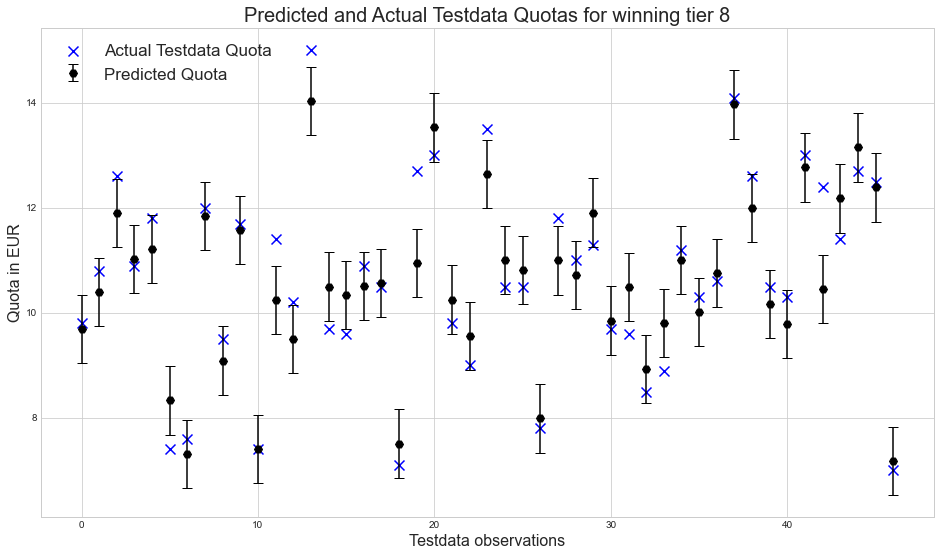

In [82]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize=(16, 9))
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
#y = np.sin(x) + dy * np.random.randn(50)
yp = compare['Predicted Quota'].to_numpy().flatten()
y = compare['Actual Testdata Quota'].to_numpy().flatten()
x = compare.index

plt.errorbar(x, yp, yerr=rmse, fmt='.k', marker="H", capsize=5, ms=8)
plt.scatter(x, y, c='blue', marker='x', s=100)
plt.legend(["Actual Testdata Quota", "Predicted Quota"], fontsize=17)
plt.title("Predicted and Actual Testdata Quotas for winning tier 8", fontsize=20)
plt.xlabel('Testdata observations', fontsize=16)
plt.ylabel('Quota in EUR', fontsize=16)
plt.show()

The root mean squared percentage error in our predictions is 5.95 % or 0.653 EUR, which is inline with our expectations to have at least an approximate ballpark figure, without necessarily hitting the exact Quota on the head each and every time. This error percentage is already mildy optimized and not just a randomly generated model with an random prediction error. We rather have to accept that other complex factors such as inter-number-relations are at play as well that were not yet taken into account already. In that light there is hardly anything more than marginal improvement possible with the prepared features in place.

#### Compare also with best single model (Epsilon-Support Vector Regression & Kernel Ridge) on Test Data

In [83]:
svrmodel = SVR(**svr_param)
svrmodel = svrmodel.fit(X_train, y_train)
y_pred = svrmodel.predict(X_test)
print('Mean Squared Error: [%.8f]' % mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error: [%.8f]' % np.sqrt(mean_squared_error(y_test, y_pred)))
print('Root Mean Squared Percentage Error: ', round(rmspe(y_test, y_pred),2), '%')
print('R2 score: [%.8f]' % metrics.r2_score(y_test, y_pred))

Mean Squared Error: [0.42263700]
Root Mean Squared Error: [0.65010537]
Root Mean Squared Percentage Error:  5.93 %
R2 score: [0.87762963]


SVR as single model prevails in this instance against the outlined stacked model. As both results are are virtually identical we waive to chart another plot.

### Predict the winning tier 8 quota for your numbers

We want to test the model with an real oberservation of 22-Jan-20 which is new data and the model was not trained for.

In [84]:
###################################################################
#predict the quota for your numbers / or an observed number drawing
my_numbers = [3, 16, 23, 33, 41, 47]
my_superzahl = [4]
date = ('22.01.20')
#predict the quota for your numbers / or an observed number drawing
###################################################################

def sparse_superzahl_df(df, numbers=1, pop=10, start=0): # custom hot encoding
    for i in range(start,pop+start):
        df.loc[:,'S' + str(i)] = pd.Series(np.zeros((len(df)))) #sparse cols
    df = df.fillna(0) # zero prefilled
    num = range(start,numbers+start)
    for index, row in df.iterrows(): # each observation
            dn = df.loc[index,'S'].copy()
            df.loc[index,'S' + str(dn)] = 1 # sparsing
    return df

def DFprediction(my_numbers, my_superzahl=0, date=['dummy']):
    import itertools
    data = [date,my_numbers, my_superzahl]
    data = list(itertools.chain.from_iterable(data))
    cols = ['Date', 'G1', 'G2','G3', 'G4','G5', 'G6', 'S']
    df = pd.DataFrame([data], columns = cols, index=[0])
    df = sparsedf(df) # reg numbers
    df = sparse_superzahl_df(df) # superzahl
    df =  df.iloc[:,8:len(df.columns)]
    X_array = df.to_numpy()
    S_observation = stack.transform(X_array)
    return np.round(model_l2.predict(S_observation),2)

print('The estimated quota for the given numbers and winning tier is: %.2f EUR' % DFprediction(my_numbers, my_superzahl), 
      '+/- RMSE %.2f EUR' % np.sqrt(mean_squared_error(y_test, y_pred)))

The estimated quota for the given numbers and winning tier is: 9.59 EUR +/- RMSE 0.65 EUR


The actual winning quota in tier 8 was 9.40 EUR. Hence the prediction was quite good. We could have predicted the quota already right after the drawing in the evening of 22nd while we do not need to wait for the official quota publication the next day. Sometimes even later than that.

## Appendix: Random Lotto Draw Generator/Sampler (Uniform distribution)

In [85]:
# k draws out of n without replacement --> use the random.sample function

# simulate how many drawings?
sampling_cycles = 314

# 6 out of 49 Lotto draw function
def lottodraw():
    import random
    draw = np.array(random.sample(range(1,50), 6))
    return np.sort(draw)

# call cycles
yy = [lottodraw() for w in range(sampling_cycles)]
# show last three lotto draw sessions
yy[306:310]

[array([20, 22, 43, 44, 47, 49]),
 array([ 4, 24, 37, 38, 39, 45]),
 array([19, 24, 33, 38, 43, 44]),
 array([ 1,  2,  3,  6, 18, 39])]

In [86]:
yy = np.array(yy).flatten()
#frequency of numbers drawn altogether
len(yy)

1884

In [87]:
# break it down to each number in the population
unique_elements, counts_elements = np.unique(yy, return_counts=True)

In [88]:
count = pd.DataFrame(counts_elements.reshape(1,-1), columns=[unique_elements])

# Expected frequency for each uniformly distributed number
counts_elements.mean()

38.44897959183673